## Introduction
The suicide rate in lots of countries have been quite high for many years, including the developing and developed countries. At the begining, we'll see the suicide rate of sex, and then the age and generation. Next we'll plot the rank of suicide rate, it's clearly to understand the distribution of the suicide rate. Finally, we'll find out the key factors of high suicide rate.

In [58]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np 
import os 
import pandas as pd
from scipy import stats
import pycountry
import geopandas

In [60]:
filename = "csv_files/master.csv"
df = pd.read_csv(filename)
print(df.head())

   country  year       ...        gdp_per_capita ($)       generation
0  Albania  1987       ...                       796     Generation X
1  Albania  1987       ...                       796           Silent
2  Albania  1987       ...                       796     Generation X
3  Albania  1987       ...                       796  G.I. Generation
4  Albania  1987       ...                       796          Boomers

[5 rows x 12 columns]


Rename the columns.

In [61]:
df.rename(columns={"suicides/100k pop":"suicides_pop","HDI for year":"HDI_for_year",
                  " gdp_for_year ($) ":"gdp_for_year"," gdp_per_capita ($) ":"gdp_per_capita",
                    "gdp_per_capita ($)":"gdp_per_capita"}, inplace=True)
print(df.columns)

Index(['country', 'year', 'sex', 'age', 'suicides_no', 'population',
       'suicides_pop', 'country-year', 'HDI_for_year', 'gdp_for_year',
       'gdp_per_capita', 'generation'],
      dtype='object')


Rearrange the dataset.

In [62]:
df["gdp_for_year"] = df["gdp_for_year"].str.replace(",","").astype(np.int64)
df["age"] = df["age"].str.replace("5-14 years","05-14 years")

We arange the country list and see how many countries are in the dataset, then calculate the suicide rate of countries.

In [63]:
df1 = df.groupby("country")["suicides_no"].sum()
country_name = list(df1.index.get_level_values(0))
len(country_name)

101

We'll map the suicide rate afterward, so we need to transfer the country name into country code.
We choose alpha3 country code.

In [64]:
countries = {}
for country in pycountry.countries:
    countries[country.name] = country.alpha_3

Double check country name if the name in country list are not the same.  

In [65]:
country_not_in_list = [i for i in country_name[:] if i not in countries.keys()]
country_not_in_list

['Czech Republic',
 'Macau',
 'Republic of Korea',
 'Saint Vincent and Grenadines']

We found that there are four country names are different, so we rename these names.

In [66]:
df.replace("Republic of Korea", "Korea, Republic of", inplace = True)
df.replace('Czech Republic', "Czechia", inplace = True)
df.replace('Macau', 'Macao', inplace = True)
df.replace('Saint Vincent and Grenadines', "Saint Vincent and the Grenadines", inplace = True)

Before ploting the suicide rate of each countries, we calcuate the suicide rate for each year, and then take the average of number as rate.

In [67]:
df_suino = df.groupby(["country","year"])["suicides_no"].sum()
df_sum = df_suino.sort_index(ascending=True)[:] * 100

df_pop = df.groupby(["country","year"]).population.sum()
df_pop_sum = df_pop.sort_index(ascending=False)[:]

df_total = df_sum / df_pop_sum
df_total.head(10)

country  year
Albania  1987    0.002694
         1988    0.002279
         1989    0.002426
         1992    0.001665
         1993    0.002600
         1994    0.001755
         1995    0.003031
         1996    0.003027
         1997    0.005710
         1998    0.005112
dtype: float64

In [68]:
country_dict={}
for country in df_total.index.get_level_values(0):
    if country not in country_dict.keys():
        country_dict[country] = df_total[country].mean()
    else:
        pass

tup = list(country_dict.items())
tup.sort(key= lambda pair:pair[1], reverse = True)

country_list = [a[0] for a in tup]
country_suicide = [a[1] for a in tup]

OK! We can plot the top 20 countries.

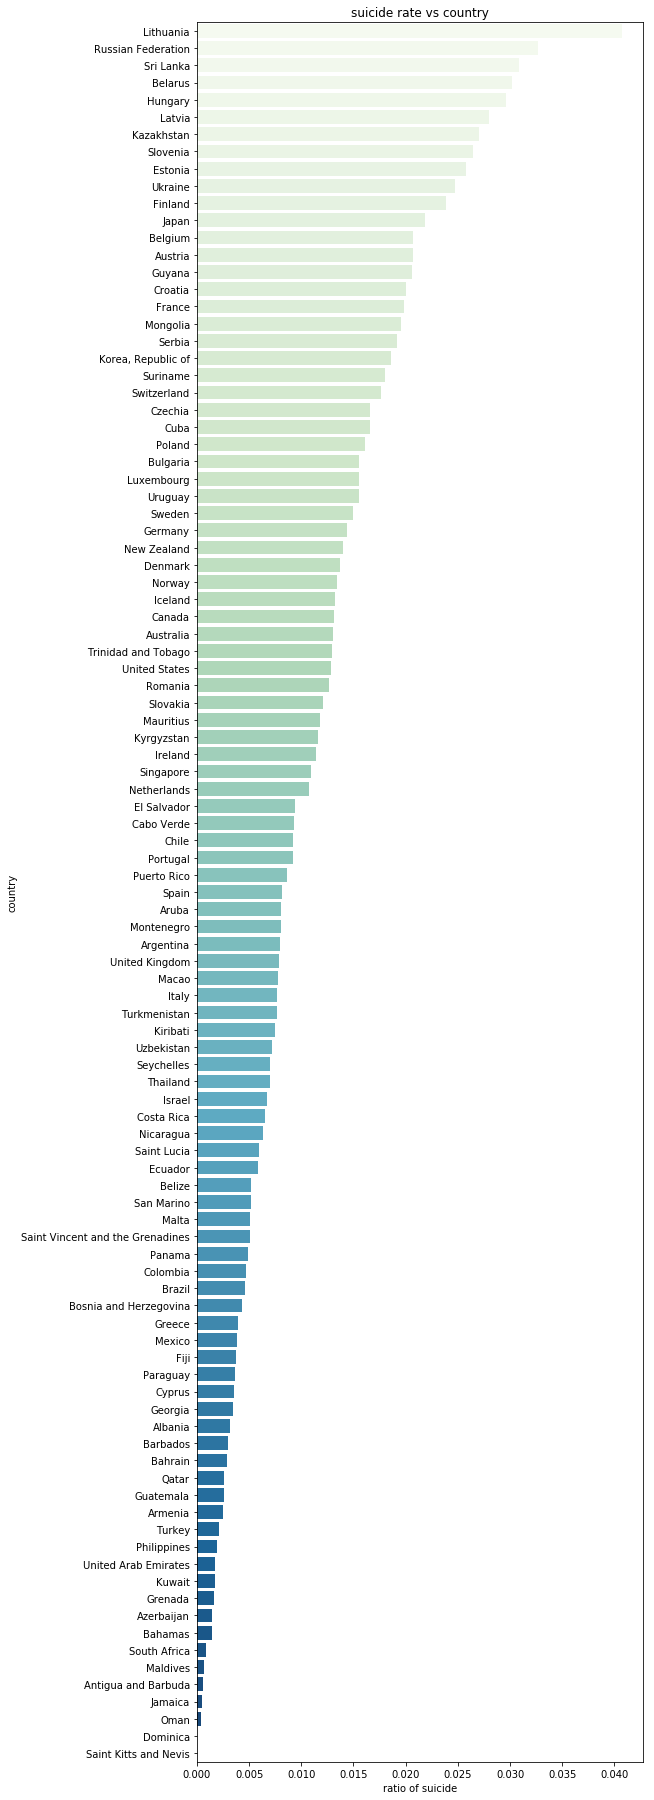

In [69]:
plt.figure(figsize=(8,32))
sns.barplot(x=country_suicide[:],y=country_list[:], palette="GnBu")
plt.xlabel("ratio of suicide")
plt.ylabel("country")
plt.title("suicide rate vs country")
plt.show()

Then we replace the keys of dictionary with alpha3 country code.

In [70]:
country_dict = dict()
for idx in range(len(country_list)):
    country_dict[countries[country_list[idx]]] = country_suicide[idx]

Define a new dataframe. The columns are country code and suicide rate.

In [71]:
new_country_dict = {}
new_country_dict["iso_a3"] = list(country_dict.keys())
new_country_dict["suicide_rate"] = list(country_dict.values())
new_country_df = pd.DataFrame(new_country_dict)
new_country_df.head()

,iso_a3,suicide_rate
0,LTU,0.040736
1,RUS,0.032703
2,LKA,0.030848
3,BLR,0.030231
4,HUN,0.029617


Use geopandas library to get information of countries, including coordinate.

Merge two dataframe together.

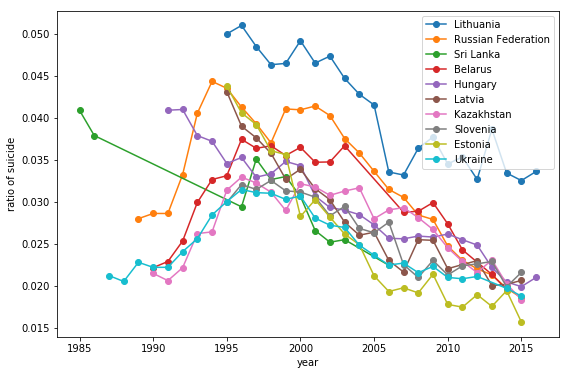

In [72]:
plt.figure(figsize = (9,6))
for country in country_list[:10]:
    plt.plot(df_total[country].index,df_total[country].values, label=country, marker="o")
plt.xlabel("year")
plt.ylabel("ratio of suicide")
plt.legend()
plt.show()

It's clearly that the suicide rate of some top10 countries dramatically increased after 1990. In addition, the rate in others are still high during 1990 to 2000. The transition to the economy and democracy in former Soviet Union countries may be the main reasons. Although there have been numerous studies of the increase in mortality, such as alcoholism, economic hardship, despression and so on, but there is still no one accepted as the most significant factor of the mortality crisis. Let's find out.

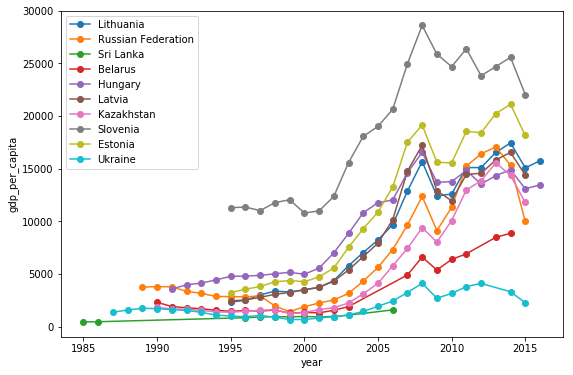

In [73]:
plt.figure(figsize = (9,6))
df_gdp = df.groupby(["country","year"]).gdp_per_capita.mean()
for country in country_list[:10]:
    plt.plot(df_gdp[country].index,df_gdp[country].values, label=country, marker="o")
plt.xlabel("year")
plt.ylabel("gdp_per_capita")
plt.legend()
plt.show()

From this image we can see that the gdp_per_capita has no differece during 1990 to 2000. In other words, the economic situation were remain stagnant and  some countries got worse until 2002, after 2005, all countries' gdp start growing. 

We also know that the whole gdp_per_capita dropped within 2008 because of the financial crisis.  However, these ratio were still better than that before 2000. To see the relationship between suicide rate and gdp_per_capita, we plot the regression plot of two parameters. 

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


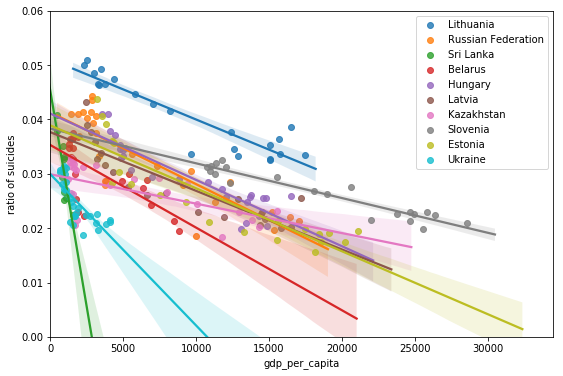

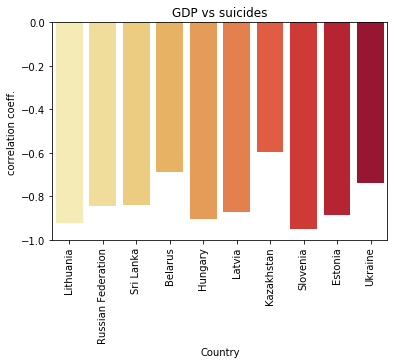

In [74]:
plt.figure(figsize = (9,6))
for country in country_list[:10]:
    sns.regplot(x=df_gdp[country].values, y=df_total[country].values, label = country)
plt.xlabel("gdp_per_capita")
plt.ylabel("ratio of suicides")
plt.ylim(0,0.06)
plt.xlim(0)
plt.legend()
plt.show()

corr_eff = {}
for country in country_list[:10]:
    slope, intercept, r_value, p_value, std_err = stats.linregress(df_gdp[country].values,df_total[country].values)
    corr_eff[country] = float(r_value)
    
sns.barplot(x=list(corr_eff.keys()), y=list(corr_eff.values()), palette = "YlOrRd")
plt.xticks(rotation = 90)
plt.xlabel("Country")
plt.ylabel("correlation coeff.")
plt.title("GDP vs suicides")
plt.show()

Amazing! The suicide rate is highly correlated to the gdp_per_capita of top10 countries. Let's find out whether others have the same trend. 


/opt/conda/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:107: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/opt/conda/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:117: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/opt/conda/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:119: RuntimeWarning: invalid value encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


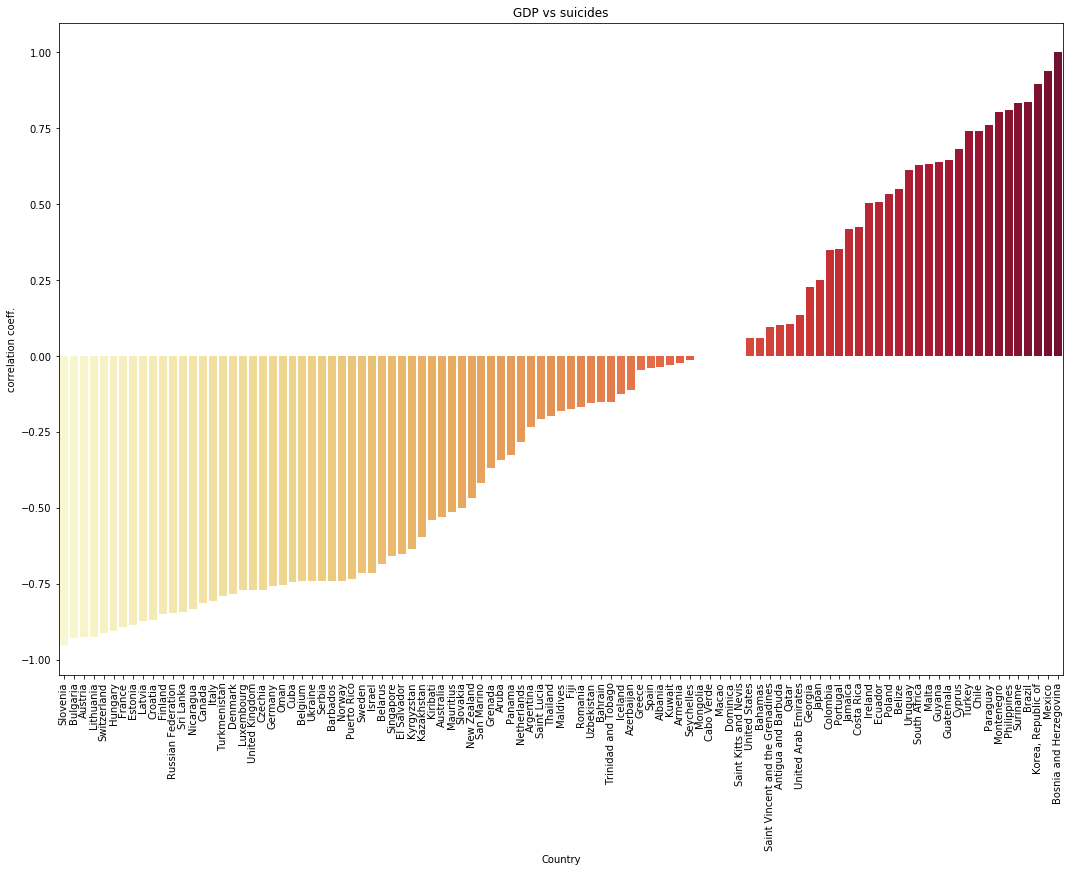

In [75]:
corr_eff = {}
p_value_eff = {}
for country in country_list[:]:
    slope, intercept, r_value, p_value, std_err = stats.linregress(df_gdp[country].values, df_total[country].values)
    corr_eff[country] = float(r_value)
    p_value_eff[country] = float(p_value)

gdp_tup = list(corr_eff.items())
gdp_tup.sort(key= lambda pair:pair[1], reverse = False)
dgp_relation = {a[0]:a[1] for a in gdp_tup}

plt.figure(figsize=(18,12))
sns.barplot(x=list(dgp_relation.keys()), y=list(dgp_relation.values()), palette = "YlOrRd")
plt.xticks(rotation = 90)
plt.xlabel("Country")
plt.ylabel("correlation coeff.")
plt.title("GDP vs suicides")
plt.show()